In [1]:
#| default_exp volume_comparisons
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import diffusion_curvature
from diffusion_curvature.core import plot_3d, diffusion_matrix, gaussian_kernel
# Reload any changes made to external files
%load_ext autoreload
%autoreload 2

# Curvature via Volume Comparison
> A signed curvature estimate using diffusion-based volume measurement

This method stems from the use 

In [2]:
#| export
import numpy as np
def coordinate_grid(dim, n_points_per_dim):
    # TODO: Generalize to dimensions above 3
    xs = [np.linspace(-1,1,n_points_per_dim) for i in range(dim)]
    match dim:
        case  2:
            M1, M2 = np.meshgrid(xs[0],xs[1])
            X = np.concatenate([M1[:,:,None], M2[:,:,None]], axis=-1).reshape(-1,dim)
            X = np.vstack([np.zeros(dim),X])
        case 3:
            M1, M2, M3 = np.meshgrid(xs[0],xs[1],xs[2])
            X = np.concatenate([M1[:,:,:,None], M2[:,:,:,None], M3[:,:,:,None]],axis=-1).reshape(-1,dim)
            X = np.vstack([np.zeros(dim),X])
        case _:
            raise NotImplementedError
    return X

In [3]:
X = coordinate_grid(dim=2,n_points_per_dim = 40)

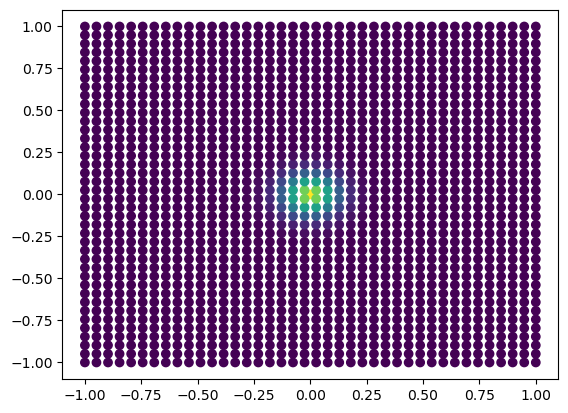

In [4]:
P = diffusion_matrix(X, kernel_type="adaptive", k = 10, anisotropic_density_normalization = 0.5, threshold_for_small_values=1e-5)
Pt = P @ P @ P @ P
plt.scatter(X[:,0],X[:,1],c=P[0])

In [4]:
def diffuse_and_count_points(
        P:np.ndarray, # diffusion matrix of graph
        t:int, # time, the number of steps of diffusion 
        threshold:float = 1e-3,
        on_singular_point = False # if true, only performs diffusion and counting on the first point
        ):
    """Diffuse for t steps and count the number of points with diffusion mass exceeding the threshold.
    Returns this count for each point in the graph.
    """
    if on_singular_point:
        diffused_point_0 = P[0]
        for i in range(t):
            diffused_point_0 = diffused_point_0 @ P
        diffused_point_0[diffused_point_0 < threshold] = 0
        print(diffused_point_0)
        nonzero_count = np.count_nonzero(diffused_point_0)
    else:
        P_t = np.linalg.matrix_power(P,t)
        P_t[P_t < threshold] = 0
        nonzero_count = np.count_nonzero(P_t, axis=1)
    return nonzero_count

In [5]:
def volume_comparison_with_lattice_by_counting(
        X:np.ndarray, # the data matrix
        dim:int, # estimated dimensionality of X
        t:int, # diffusion time parameter, number of steps to take
        threshold:float = 1e-3,
        low_pass_filter_curvatures = True,
):
    # construct lattice with dimension and comparable number of points
    n_points_per_dim = int(len(X)**(1/dim))
    X_euclidean = coordinate_grid(dim=dim, n_points_per_dim=n_points_per_dim)
    print("constructed grid with size ",len(X_euclidean))
    P_euclidean = diffusion_matrix(X_euclidean, kernel_type="adaptive", k = 10, anisotropic_density_normalization = 0.5, threshold_for_small_values=1e-5)
    print(P_euclidean)
    count_euclidean_one_point = diffuse_and_count_points(P_euclidean,t=t,threshold=threshold, on_singular_point=True)
    count_euclidean = np.repeat(count_euclidean_one_point, len(X))
    # perform the same count on the passed data
    P_manifold = diffusion_matrix(X, kernel_type="adaptive", k = 10, anisotropic_density_normalization = 0.5,threshold_for_small_values=1e-5)
    count_manifold = diffuse_and_count_points(P_manifold,t=t,threshold=threshold)
    # compare the counts
    curvature_from_count = 1 - count_manifold[:,None]/count_euclidean[:,None]
    if low_pass_filter_curvatures:
        curvature_from_count = P_manifold @ curvature_from_count
    return curvature_from_count, count_manifold, count_euclidean


# Tests
## On Sphere

In [6]:
from diffusion_curvature.datasets import sphere

In [7]:
X, ks = sphere(2000)

In [8]:
k_counts, count_m, count_e = volume_comparison_with_lattice_by_counting(X, dim=2, t = 2,threshold=1e-3)

constructed grid with size  1937
[[0.05523472 0.         0.         ... 0.         0.         0.        ]
 [0.         0.07923703 0.08001428 ... 0.         0.         0.        ]
 [0.         0.07462106 0.08670523 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.07054903 0.0689339  0.0516135 ]
 [0.         0.         0.         ... 0.07263048 0.08670523 0.07462106]
 [0.         0.         0.         ... 0.05831167 0.08001428 0.07923703]]
[0.01488847 0.         0.         ... 0.         0.         0.        ]


In [9]:
count_m

array([127, 120, 139, ..., 126, 117, 126])

In [10]:
count_e

array([189, 189, 189, ..., 189, 189, 189])

In [11]:
k_counts

array([[0.31075721],
       [0.34373779],
       [0.30279401],
       ...,
       [0.28013696],
       [0.33892693],
       [0.30579878]])

## On Torus

In [12]:
from diffusion_curvature.datasets import torus

In [13]:
X, ks = torus(n=2000)

In [14]:
k_counts, count_m, count_e = volume_comparison_with_lattice_by_counting(X, dim=2, t = 5,threshold=1e-3, low_pass_filter_curvatures=False)

constructed grid with size  962
[[0.03792797 0.         0.         ... 0.         0.         0.        ]
 [0.         0.07923703 0.08001428 ... 0.         0.         0.        ]
 [0.         0.07462106 0.08670523 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.07054903 0.0689339  0.0516135 ]
 [0.         0.         0.         ... 0.07263048 0.08670523 0.07462106]
 [0.         0.         0.         ... 0.05831167 0.08001428 0.07923703]]
[0.00678616 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

In [15]:
count_m

array([238, 268, 225, ..., 220, 265, 230])

In [16]:
count_e

array([286, 286, 286, ..., 286, 286, 286])

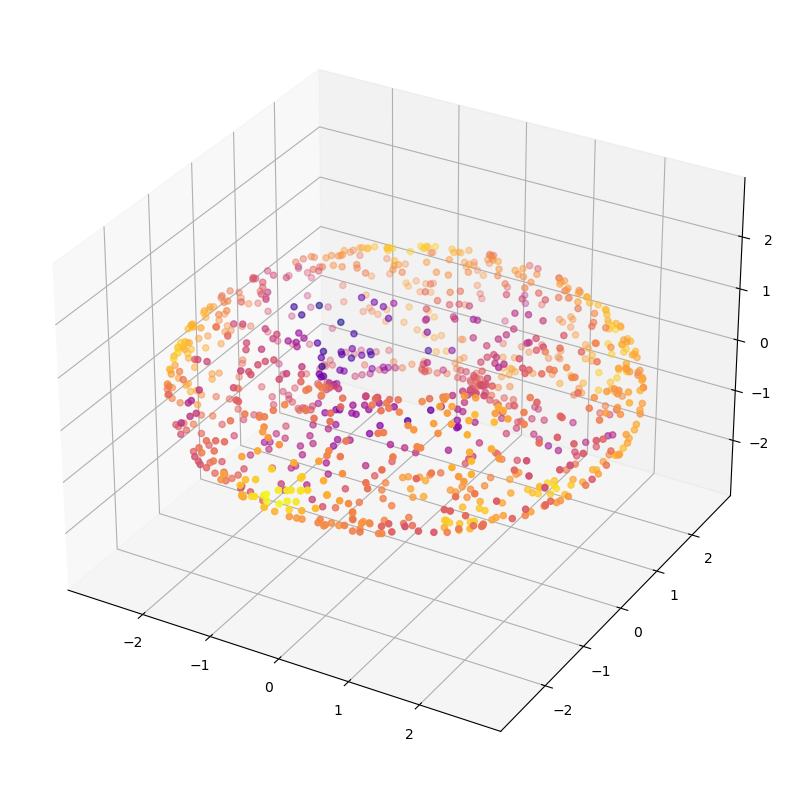

In [18]:
plot_3d(X,k_counts)

In [19]:
min(k_counts)

array([-0.16433566])

In [20]:
max(k_counts)

array([0.33216783])

## On Hyperboloid

In [ ]:
from diffusion_curvature.datasets import hyperboloid

In [ ]:
X, ks = hyperboloid(2000)

In [ ]:
k_counts, count_m, count_e = volume_comparison_with_lattice_by_counting(X, dim=2, t = 5,threshold=1e-3, low_pass_filter_curvatures=False)

In [ ]:
k_counts

In [ ]:
min(k_counts)

In [ ]:
count_m

In [ ]:
count_e

In [ ]:
plot_3d(X, k_counts)